[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/aws/sagemaker/sagemaker-pinecone-rag.ipynb)

# Module 02 - Data Query


This module contains notebook code to:
* Query the data from Pinecone Index
* Perform semantic search
* Generate RAG response using Amazon Bedrock 


*******************************************************************************************************************

### Install required libraries

In [ ]:
%pip install --quiet --upgrade \
    pinecone-notebooks \
    python-dotenv \
    pinecone \
    "rich[jupyter]"

To begin, we will initialize Amazon Bedrock and Pinecone that we'll need to use throughout the walkthrough.

In [2]:
# Standard library imports
import os
import re
import time
import getpass
import difflib
from html import unescape
import json
import getpass

# Third-party imports
import requests
from tqdm import tqdm
from dotenv import load_dotenv
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

# Pinecone and Rich libraries
from pinecone import Pinecone

from rich import print as rprint
from rich.console import Console
from rich.table import Table
from rich import box

# AWS Library imports
import boto3
import botocore
from botocore.config import Config

### Initialize Pinecone

In [ ]:
PINECONE_API_KEY = getpass.getpass("Enter Pinecone API Key")
pc = Pinecone(api_key=PINECONE_API_KEY)

In [4]:
index_name = 'pinecone-cohere-workshop' #Provide Pinecone Index name that we created in the 'Create Pinecone Index' section
namespace = 'agentic-rag'

### Initialize Bedrock

#### Use the instruction provided in the link to add Amazon Bedrock permissions to the IAM role that will use this SageMaker notebook [Using SageMaker Notebooks](https://docs.aws.amazon.com/bedrock/latest/userguide/api-setup.html#api-using-sage).

In [6]:
config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-west-2'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

### Initialize Pinecone Index and describe stats

In [7]:
index = pc.Index(index_name)

In [ ]:
print(index.describe_index_stats())

### Query the data

Now we're ready begin querying our LLM with a **R**etrieval **A**ugmented **G**eneration (RAG) pipeline. Let's see how this will work step-by-step first.

#### Step 1. Generate vector embeddings of the text query 
#### Step 2. Perform Semantic Search and get relevant data to compose Context
#### Step 3. Invoke LLM with the Prompt, Context and Question

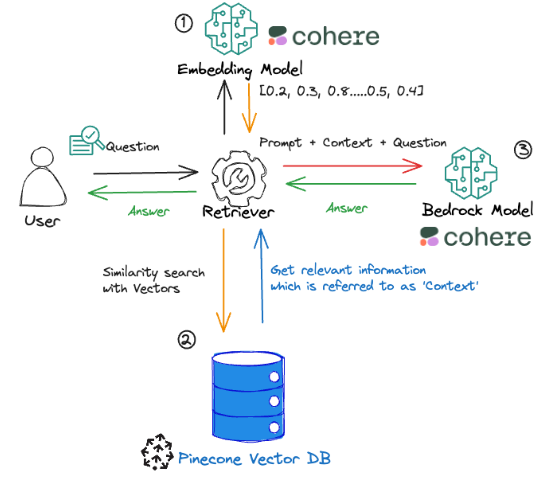

First we create our _query embedding_ and use it to query Pinecone:

In [9]:
def cohere_embed_query(docs: str, input_type: str) -> list[float]:
    """
    Generate text embedding by using the Cohere Embed model.
    Args:
        docs: string of text to embed.
        input_type: select between [search_document, search_query, classification, clustering, image]
    Returns:
        dict: embeddings in float type.
    """

    body = json.dumps({
        "texts": [docs],
        "input_type": input_type,
        "embedding_types": ["float"]

    })
    
    model_id = 'cohere.embed-english-v3'
    accept = 'application/json' 
    content_type = 'application/json'
    
    # Invoke model 
    response = bedrock.invoke_model(
        body=body, 
        modelId=model_id, 
        accept=accept, 
        contentType=content_type
    )
    
    # Parse response
    response_body = json.loads(response['body'].read())
    embedding = response_body.get('embeddings')['float'][0]
    
    return embedding

In [10]:
def query_db(query: list) -> list:
    """
    Query the Pinecone index with an optional rerank.

    Args:
        query (str): The query string.
        embed_with_rerank (bool, optional): Whether to apply reranking. Defaults to False.
        filter (dict, optional): Filter criteria for the query. Defaults to None.

    Returns:
        list: A list of hit records from the index.
    """
    query_embedding = cohere_embed_query(QUERY, input_type="search_query")

    search_results = index.query(
        namespace=namespace,
        vector=query_embedding,
        fields=["chunk_text"],
        top_k=20
    )

    document_ids = []
    
    for result in search_results['matches']:
        document_ids.append(result['id'])

    fetch_results = index.fetch(ids=document_ids, namespace=namespace)

    documents_retrieved = []

    for document_id in document_ids:
        text = fetch_results.vectors[document_id]['metadata']['chunk_text']
        documents_retrieved.append((document_id, text))

    return documents_retrieved

In [11]:
QUERY = "Changes in Compaq's product offerings and their impacts on sales"
documents_retrieved = query_db(QUERY)

In [ ]:
documents_retrieved[:3]

In [13]:
def rerank_results(docs: list):

    documents_text = [text for doc_id, text in documents_retrieved]

    
    model_id = 'cohere.rerank-v3-5:0'
    accept = 'application/json' 
    content_type = 'application/json'
    
    body = json.dumps({
        "query": QUERY,
        "documents": documents_text,
        "api_version": 2
    })
    
    response = bedrock.invoke_model(
        modelId=model_id,
        contentType=content_type,
        accept=accept, 
        body=body
    )
    rerank_results = json.loads(response.get('body').read())["results"]

    documents_reranked = []
    for result in rerank_results:
        idx = result["index"] 
        score = result["relevance_score"]
        doc_id, doc_text = documents_retrieved[idx]
        documents_reranked.append((doc_id, doc_text, score))
    
    # Sort by score if needed
    documents_reranked.sort(key=lambda x: x[2], reverse=True)

    return documents_reranked

In [14]:
documents_reranked = rerank_results(documents_retrieved)

In [ ]:
documents_reranked[:3]